In [1]:
from sklearn.datasets import fetch_20newsgroups

In [2]:
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')

print("Training texts:", len(train_data.data))
print("Test texts:", len(test_data.data))

Training texts: 11314
Test texts: 7532


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# Pasamos el fichero a una lista (una línea por item)
with open('words.txt') as f:
    dictionary = f.read().splitlines()

In [5]:
vectorizer = CountVectorizer(binary= False, vocabulary=dictionary, stop_words='english', ngram_range = (1,1))

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
import numpy as np

In [14]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [15]:
train_vector_data = vectorizer.fit_transform(train_data.data)
test_vector_data = vectorizer.fit_transform(test_data.data)

In [17]:
feature_names = vectorizer.get_feature_names()

In [19]:
write_terms(feature_names, None, train_vector_data, 1)

Mensaje 1 vectorizado: ['acceleration' 'adapters' 'answered' 'article' 'attained' 'brave' 'cards'
 'clock' 'days' 'detailing' 'disk' 'especially' 'experiences' 'final'
 'floppy' 'floppies' 'functionality' 'heat' 'hour' 'keywords' 'knowledge'
 'lines' 'message' 'network' 'number' 'organization' 'oscillator'
 'posting' 'procedure' 'rated' 'reports' 'requested' 'send' 'shared'
 'sinks' 'souls' 'speed' 'subject' 'summary' 'summarizing' 'thanks'
 'upgrade' 'upgraded' 'usage'] 



Procedemos a elegir 3 mensajes de cada tipo

In [21]:
import random

In [22]:
len(test_data.target)

7532

In [23]:
test_data.target[103]

15

In [24]:
#while the last element of the sum of all the previous elements (which is the sum of the total selectec texts) 
#    is less than the desired amount, it will keep choosing candidates

selected = [0]*len(test_data.target_names)

number_samples = 3

selected_index = [0]*len(test_data.target_names)*number_samples

while (np.cumsum(selected)[-1] < len(selected)*number_samples):

    #Indice aleatorio de la lista de mensajes
    index = random.randint(0, len(test_data.target))
    #cat = numero de la categoria a la que pertenece el índice elegido
    cat = test_data.target[index]
    #Comprobamos que no haya ya 3 elementos de la categoría a la que pertenezca el index y lo añadimos a la cuenta y a la lista de índices
    #La lista de índices estará ordenada por categorías
    if(selected[cat] < 3):
        selected_index[cat*number_samples + selected[cat]] = index
        selected[cat] += 1

Igual merece más la pena ponerlo en una matriz de N*M siendo N el número de elementos por cada clase y M el número de clases

In [28]:
selected_index

[2670,
 400,
 6328,
 1204,
 7116,
 4182,
 4505,
 5625,
 3610,
 4562,
 354,
 5535,
 5762,
 4214,
 4980,
 2557,
 4002,
 1928,
 6554,
 3541,
 961,
 293,
 5871,
 903,
 4714,
 4001,
 88,
 6062,
 4958,
 6488,
 5753,
 765,
 6762,
 5982,
 1932,
 3182,
 4460,
 4231,
 4671,
 3882,
 2280,
 3374,
 3476,
 1685,
 7301,
 4689,
 824,
 4044,
 2600,
 6665,
 1535,
 308,
 6889,
 1773,
 1704,
 1704,
 7293,
 2233,
 576,
 7404]

In [29]:
new_shape = np.reshape(selected_index, [20,3])

In [30]:
print(new_shape)

[[2670  400 6328]
 [1204 7116 4182]
 [4505 5625 3610]
 [4562  354 5535]
 [5762 4214 4980]
 [2557 4002 1928]
 [6554 3541  961]
 [ 293 5871  903]
 [4714 4001   88]
 [6062 4958 6488]
 [5753  765 6762]
 [5982 1932 3182]
 [4460 4231 4671]
 [3882 2280 3374]
 [3476 1685 7301]
 [4689  824 4044]
 [2600 6665 1535]
 [ 308 6889 1773]
 [1704 1704 7293]
 [2233  576 7404]]


In [32]:
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
cosSim1 = cosine_similarity(train_vector_data[2252], train_vector_data)

A ver, entonces, lo que creo que hay que hacer es:

    1) Hacer el cosine similarity para cada una de las 60 indices que hemos elegido.
    2) Agruparlos de 3 en 3 ya que es el número de muestras que nos dicen que cojamos (ponerlo como un parámetro)
    3) Ordenar los 20 arrays, en total cada uno tendrá (número de textos)*3 elementos
    4) Cuando tengamos todos los elementos ordenador hacemos lo de la exhaustividad (recall, es decir de entre todos los que han dado positivo (que se parecen al texto objetivo) cuantos son realmente de la misma categoría(True Pos/(True Pos + False Neg))) entre valores de 3 y 10. Eso significa que tenemos que ver para los mejores X valores (entre 3 y 10) cuantos son de la misma categoría que la clase que estamos comparando
    5) Hacer la media de los 

Nononono a ver

Lo que piden de:  la precisión de la lista de resultados con nivel de exhaustividad 3 y 10.

Lo que hay que hacer es: De los X valores que más se parezcan entre los X primeros recuperados. Por lo que símplemente es coger y decir: Si para un nivel de exhaustividad 7, cogemos los 7 elementos que más se parezcan a los textos que hemos metido, después comprobamos de esos 7 cuantos son de la clase a la que perteneces los mensajes seleccionados antes.

Entonces, después cogemos esos 8 resultados (los valores de 3 a 10) y hacemos la media. Eso para cada clase.

Así podemos ver cual es la clase que más parecidos tiene o algo así (?)


Y luego hay que hacer lo mismo pero con el TF-IDF

la duda que luego voy a preguntar es que si lo de exhaustivodad de nivel 5 por ejemplo, significa realmente que solo hay que coger los 5 elementos más TOP, me parece raro porque hay miles y miles y quedarse con tan pocos se me hace raro

Intentar hacer la movida con funciones para que quede guay y bien indicado

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [46]:
def sortSimilarityIndex(cosSim):
    
    for i, category in enumerate(cosSim):
        for j, sim in enumerate(category):
            cosSim[i][j] = np.argsort(-sim)
    return cosSim

In [47]:
def cosSim_calc2(indexes, test_vector, train_vector):
    cosSim = np.zeros(indexes.shape, object)
    for i, indexList in enumerate(indexes):
        for j, index in enumerate(indexList):
            cosSim[i][j] = cosine_similarity(test_vector[index], train_vector)[0]
    return cosSim

In [48]:
cos_sim2 = cosSim_calc2(new_shape,test_vector_data, train_vector_data)

In [50]:
cos = sortSimilarityIndex(cos_sim2)

In [53]:
print(cos)

[[array([ 7883,  3787,  6500, ..., 10433,  1541,  1554], dtype=int64)
  array([4586,  833, 1634, ..., 1541, 3382, 9412], dtype=int64)
  array([7368, 4885, 5200, ...,  144, 1541, 9412], dtype=int64)]
 [array([   12,  5652,  4994, ...,  1541, 10433,  9412], dtype=int64)
  array([ 7071,  6672, 10029, ...,   144,  1541,  9412], dtype=int64)
  array([4913, 2285, 5302, ...,  144, 9412, 1541], dtype=int64)]
 [array([4588, 7226, 5692, ..., 1541, 8519, 9412], dtype=int64)
  array([4817, 5521, 8320, ...,  144, 1541, 9412], dtype=int64)
  array([8489, 1547, 1603, ..., 8519, 1541, 9412], dtype=int64)]
 [array([8506, 9358, 3533, ..., 1541, 8519, 9412], dtype=int64)
  array([5046, 7746, 9999, ...,  144, 1541, 9412], dtype=int64)
  array([ 662, 7722, 8654, ...,  144, 1541, 9412], dtype=int64)]
 [array([6680, 4278, 9692, ...,  144, 8519, 9412], dtype=int64)
  array([ 6487,  3292,  1421, ..., 10126,  3382,  9412], dtype=int64)
  array([ 335, 1373, 5235, ...,  144, 1541, 9412], dtype=int64)]
 [array([41

In [56]:
cos_sim = cosSim_calc(selected_index, 3, len(train_data.data))

[2670, 400, 6328, 1204, 7116, 4182, 4505, 5625, 3610, 4562, 354, 5535, 5762, 4214, 4980, 2557, 4002, 1928, 6554, 3541, 961, 293, 5871, 903, 4714, 4001, 88, 6062, 4958, 6488, 5753, 765, 6762, 5982, 1932, 3182, 4460, 4231, 4671, 3882, 2280, 3374, 3476, 1685, 7301, 4689, 824, 4044, 2600, 6665, 1535, 308, 6889, 1773, 1704, 1704, 7293, 2233, 576, 7404]
60
11314 20
0
0.8742442937592402
1
0.4196271637081413
2
0.6859943405700353
3
0.7655147691170537
4
0.5139561687500467
5
0.5066736905472307
6
0.42562826537937437
7
0.36514837167011077
8
0.5591491340752626
9
0.523632454313116
10
0.8340576562282994
11
0.6274558051381586
12
0.5998866106008964
13
0.3714427594782296
14
0.6982972487551755
15
0.40089186286863654
16
0.45112017423725
17
0.7956640830660473
18
0.44543540318737407
19
0.41780135648225064


Ahora toca hacer los niveles de exhaustividad con la información bien colocadita que tenemos aquí

Lo que vamos a hacer es dejar en una matriz de N*M los resultados del recall
    Siendo N=número de clases y M=niveles de exhaustividad

In [203]:
def nivelesExhaustividad(data, niveles):
    #exhaustN = np.zeros(data.shape, object)
    exhaust = []
    
    for nivel in niveles:
        exhaustN = np.zeros(data.shape, object)
        for i, indexList in enumerate(data):
            for j, index in enumerate(indexList):
                exhaustN[i][j] = data[i][j][:nivel:1]
        exhaust.append(exhaustN)
        
        exhaustNP = np.array(exhaust)
        
    return exhaustNP

In [213]:
niveles = [3,10, 40]
exhaustIndex = nivelesExhaustividad(cos, niveles)

In [205]:
print(exhaustIndex)

[[[array([7883, 3787, 6500], dtype=int64)
   array([4586,  833, 1634], dtype=int64)
   array([7368, 4885, 5200], dtype=int64)]
  [array([  12, 5652, 4994], dtype=int64)
   array([ 7071,  6672, 10029], dtype=int64)
   array([4913, 2285, 5302], dtype=int64)]
  [array([4588, 7226, 5692], dtype=int64)
   array([4817, 5521, 8320], dtype=int64)
   array([8489, 1547, 1603], dtype=int64)]
  [array([8506, 9358, 3533], dtype=int64)
   array([5046, 7746, 9999], dtype=int64)
   array([ 662, 7722, 8654], dtype=int64)]
  [array([6680, 4278, 9692], dtype=int64)
   array([6487, 3292, 1421], dtype=int64)
   array([ 335, 1373, 5235], dtype=int64)]
  [array([4147, 3698, 6678], dtype=int64)
   array([4688, 8835, 3713], dtype=int64)
   array([ 3404, 10305,   290], dtype=int64)]
  [array([10150,  2080,  1594], dtype=int64)
   array([8484,  176, 4474], dtype=int64)
   array([2055, 1018,  929], dtype=int64)]
  [array([8484, 4474, 8537], dtype=int64)
   array([8484, 4757, 1967], dtype=int64)
   array([4351, 97

In [66]:
dir(train_data)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [201]:
def calcPrecision(exhaustIndex, train_data):
    precision = np.zeros(exhaustIndex.shape, object)
    
    for i, nivel in enumerate(exhaustIndex):
        for j, indexList in enumerate(nivel):
            for k, BestIndexes in enumerate(indexList):
                prec = 0
                for index in BestIndexes:
                    #Si el indice del train data coincide con la j, es bueno
                    if(train_data[index] == j):
                        prec += 1
                prec /= len(BestIndexes)
                
                precision[i][j][k] = prec
                
    return precision

In [214]:
precision = calcPrecision(exhaustIndex, train_data.target)

In [207]:
precision

array([[[0.6666666666666666, 0.6666666666666666, 1.0],
        [0.0, 0.0, 0.3333333333333333],
        [0.0, 0.3333333333333333, 1.0],
        [0.6666666666666666, 1.0, 1.0],
        [0.0, 0.6666666666666666, 0.0],
        [1.0, 0.0, 1.0],
        [0.3333333333333333, 0.6666666666666666, 0.3333333333333333],
        [0.0, 0.3333333333333333, 0.0],
        [0.3333333333333333, 0.3333333333333333, 1.0],
        [0.3333333333333333, 0.6666666666666666, 1.0],
        [1.0, 0.6666666666666666, 0.6666666666666666],
        [0.6666666666666666, 0.0, 0.3333333333333333],
        [0.6666666666666666, 0.3333333333333333, 0.6666666666666666],
        [0.3333333333333333, 1.0, 0.0],
        [1.0, 0.0, 1.0],
        [0.6666666666666666, 0.6666666666666666, 0.3333333333333333],
        [1.0, 0.6666666666666666, 0.3333333333333333],
        [1.0, 0.0, 0.6666666666666666],
        [0.6666666666666666, 0.6666666666666666, 0.0],
        [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]],

   

In [99]:
precision[0][0]

array([0.6666666666666666, 0.6666666666666666, 1.0], dtype=object)

In [216]:
def precMedia(precisiones):
    precMedia = np.zeros(precisiones.shape, object)
    # Ahora reducimos una dimansión, porque al hacer la media los "num_samples" de valores se reducirán a solo 1
    precMedia = precMedia[:, :, 0]

    for i, nivel in enumerate(precisiones):
        for j, clase in enumerate(nivel):
            print(clase)
            precMedia[i][j] = clase.mean()
            
    return precMedia

In [217]:
precMedia = precMedia(precision)

[0.6666666666666666 0.6666666666666666 1.0]
[0.0 0.0 0.3333333333333333]
[0.0 0.3333333333333333 1.0]
[0.6666666666666666 1.0 1.0]
[0.0 0.6666666666666666 0.0]
[1.0 0.0 1.0]
[0.3333333333333333 0.6666666666666666 0.3333333333333333]
[0.0 0.3333333333333333 0.0]
[0.3333333333333333 0.3333333333333333 1.0]
[0.3333333333333333 0.6666666666666666 1.0]
[1.0 0.6666666666666666 0.6666666666666666]
[0.6666666666666666 0.0 0.3333333333333333]
[0.6666666666666666 0.3333333333333333 0.6666666666666666]
[0.3333333333333333 1.0 0.0]
[1.0 0.0 1.0]
[0.6666666666666666 0.6666666666666666 0.3333333333333333]
[1.0 0.6666666666666666 0.3333333333333333]
[1.0 0.0 0.6666666666666666]
[0.6666666666666666 0.6666666666666666 0.0]
[0.3333333333333333 0.3333333333333333 0.3333333333333333]
[0.3 0.6 0.9]
[0.0 0.0 0.4]
[0.3 0.3 0.8]
[0.4 1.0 0.8]
[0.2 0.6 0.0]
[0.4 0.0 0.5]
[0.6 0.6 0.3]
[0.1 0.1 0.1]
[0.3 0.1 1.0]
[0.1 0.4 0.9]
[0.5 0.5 0.3]
[0.5 0.0 0.8]
[0.2 0.1 0.5]
[0.2 0.9 0.0]
[0.6 0.0 1.0]
[0.3 0.6 0.2]
[

In [110]:
precMedia[0]

array([0.7777777777777777, 0.1111111111111111, 0.4444444444444444,
       0.8888888888888888, 0.2222222222222222, 0.6666666666666666,
       0.4444444444444444, 0.1111111111111111, 0.5555555555555555,
       0.6666666666666666, 0.7777777777777777, 0.3333333333333333,
       0.5555555555555555, 0.4444444444444444, 0.6666666666666666,
       0.5555555555555555, 0.6666666666666666, 0.5555555555555555,
       0.4444444444444444, 0.3333333333333333], dtype=object)

In [90]:
from matplotlib import pyplot as plt 

In [197]:
def imprimirGraficas(info, niveles, clases):
    fig, ax = plt.subplots()
    
    #lt.figure(figsize=(16,7))
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(clases)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(clases)

    ylabel = np.arange(0.0, 1.0, 0.1)
    ax.set_yticks(ylabel)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    ax.set_title("Precisión media con diferentes niveles de exhaustividad")
    fig.set_size_inches(14,8)
    fig.tight_layout()
    
    
    for i, nivel in enumerate(info):
        print(nivel)
        ax.plot(clases, nivel, label = "Nivel exhaustividad " + str(niveles[i]))
    
    
    
    plt.legend(framealpha=1, frameon=True);
    
    
    
    
    
    plt.show()

[0.7777777777777777 0.1111111111111111 0.4444444444444444
 0.8888888888888888 0.2222222222222222 0.6666666666666666
 0.4444444444444444 0.1111111111111111 0.5555555555555555
 0.6666666666666666 0.7777777777777777 0.3333333333333333
 0.5555555555555555 0.4444444444444444 0.6666666666666666
 0.5555555555555555 0.6666666666666666 0.5555555555555555
 0.4444444444444444 0.3333333333333333]
[0.6 0.13333333333333333 0.4666666666666666 0.7333333333333334
 0.26666666666666666 0.3 0.5 0.10000000000000002 0.4666666666666666
 0.4666666666666666 0.43333333333333335 0.43333333333333335
 0.26666666666666666 0.3666666666666667 0.5333333333333333
 0.36666666666666664 0.6333333333333333 0.5 0.2333333333333333
 0.26666666666666666]
[0.4583333333333333 0.125 0.44166666666666665 0.5833333333333334
 0.19166666666666665 0.2833333333333334 0.3333333333333333
 0.19166666666666665 0.225 0.44166666666666665 0.35833333333333334 0.325
 0.19166666666666665 0.30833333333333335 0.3833333333333333
 0.19999999999999998

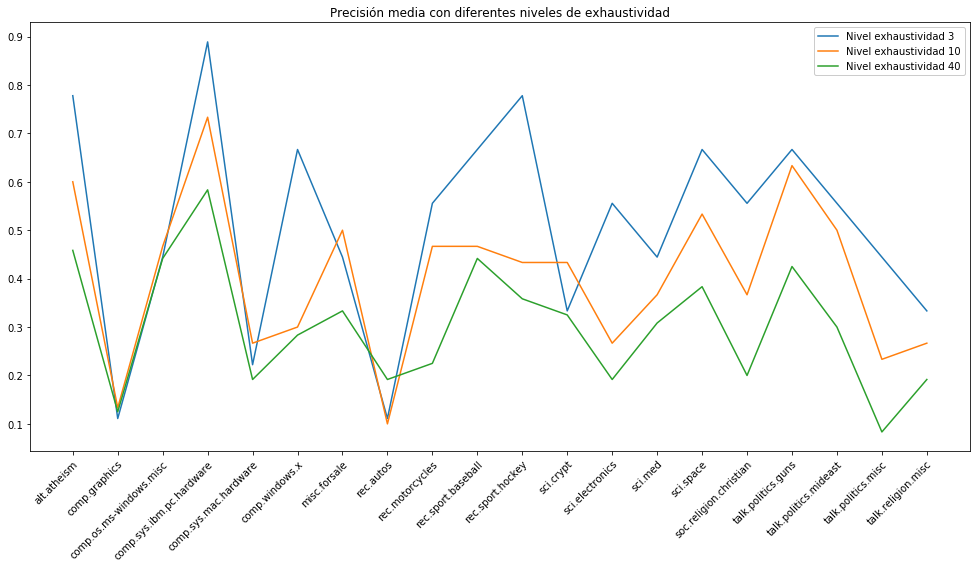

In [218]:
imprimirGraficas(precMedia, niveles, train_data.target_names)